In [17]:
%%html
<style>
.code_cell .run_this_cell {
    display: none;
}
</style>

In [18]:
# load cleaned CD data and make pretty figues
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
pi=np.pi

# swap commented lines below to examine only 'random' sessions
# type_use = ['R','RT'] # no structured sessions, run this for control analyes
type_use = ['S4','R','RT','S4O','S4R','RB'] # all sessions

from multiprocessing import Pool
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [19]:
def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)

import matplotlib
cmap = matplotlib.cm.get_cmap('Dark2')
ct = cmap(np.linspace(0,1,4))

plt.rcParams.update({'font.size': 14
                    })

In [20]:
def ori_plot():
    plt.xlim(-90,90)
    plt.xticks((-90,-45,0,45,90))
    
def sem_plot(x,y,axs=0,within_E=0,do_line=1,**args):
    # x is assumed to be examples x len(y)
    n_ex,n_points =  y.shape
    assert n_points==len(x), 'x not correct shape'
    m_y = np.mean(y,0)
    if within_E:
        y_use = (y.T-np.mean(y,1)).T
        s_y = np.std(y_use,0)/np.sqrt(n_ex)
    else:
        s_y = np.std(y,0)/np.sqrt(n_ex)
    if axs==0:
        plt.fill_between(x,m_y-s_y,m_y+s_y,**args)
        if do_line:
            plt.plot(x,m_y,'k')
    else:
        axs.fill_between(x,m_y-s_y,m_y+s_y,**args)
        if do_line:
            axs.plot(x,m_y,'k')
        
x = np.arange(-90,90,dtype=float)
def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

def std_e(x): return np.nanstd(x,0)/np.sqrt(len(x))

In [21]:
def nan_sem_plot(x,y,axs=0,within_E=0,**args):
    # x is assumed to be examples x len(y)
    n_ex,n_points =  y.shape
    n_ex = np.sum(~np.isnan(y),0)
    assert n_points==len(x), 'x not correct shape'
    m_y = np.nanmean(y,0)
    if within_E:
        y_use = (y.T-np.nanmean(y,1)).T
        s_y = np.nanstd(y_use,0)/np.sqrt(n_ex)
    else:
        s_y = np.nanstd(y,0)/np.sqrt(n_ex)
    if axs==0:
        plt.fill_between(x,m_y-s_y,m_y+s_y,**args)
        plt.plot(x,m_y,'k')
    else:
        axs.fill_between(x,m_y-s_y,m_y+s_y,**args)
        axs.plot(x,m_y,'k')

# Download and clean data

In [22]:
# dat_loc = '/Users/tim/py_code/CD_Task/CD_data_clean.csv'
dat_loc = '../Data/CD_data_clean.csv'
dat = pd.read_csv(dat_loc,index_col=0)
S_og = dat[np.isin(dat.seq_type,type_use)].copy()

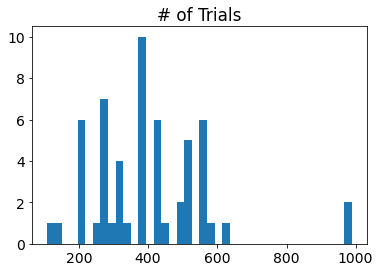

In [23]:
# clean... remove subjects with fewer than 100 trials or acc below 55%
subj_use = np.array([s[:7] for s in S_og.subject]) # fix buggy subj names
S_og['subject'] = subj_use
S_og['subj'] = S_og['subject']

S = S_og.copy()

n_start = len(S.subject.unique())
subj_acc = S.groupby('subject')['correct'].mean().reset_index()
subj_work = S.groupby('subject')['correct'].size().reset_index()

min_acc, min_trials = 0.6,200

too_bad = subj_acc.subject[subj_acc.correct<min_acc]
too_lazy = subj_work.subject[subj_work.correct<min_trials]
plt.hist(subj_work.correct,40)
plt.title('# of Trials')
plt.show()

bad_subject = np.unique(np.concatenate((too_lazy,too_bad)))
S = S[~S.subject.isin(bad_subject)]
S.loc[S.RT==-999,'respCW'] = np.nan

d_ori = np.concatenate(([0],wrap(S.orient0[:-1].values - S.orient0[1:].values)))
d_ori[S.trial==0] = np.nan
S['d_ori']=d_ori

d_stim = wrap(S.orient0.values-S.orient1.values)
S['d_stim'] = d_stim


ind0 = np.where(S.trial.values==0)[0]
ind_last = ind0[1:]-1
S['ind_last'] = False
S['ind_last'].values[ind_last]=True

good_task = (S.trial>1)&(~S.respCW.isna())&(np.abs(S.d_stim)<15)
grouper = S['d_ori'][good_task].values
d_use_radians = d_stim[good_task]/90*pi
observations = S['respCW'].values[good_task]
correct = S['correct'].values[good_task]
d_ori = d_ori[good_task]
d_stim = d_stim[good_task]
d_probe = -d_stim

# Serial Dependence

In [24]:
def do_bining(bns,overlap,grouping_var,var,var2=[-999],flip=1,prior_gauss=[4,0],want_var=0,n_boot=1):
    global obs, d_use_deg
    n_bns=len(bns)
    if var2[0]!=-999:
        do_SDT=1
        out = np.zeros((2,len(bns),n_boot))
            
        if flip:
            grouping_var = np.concatenate((grouping_var,-grouping_var))
            var = np.concatenate((var,(var==0)*1))
            var2 = np.concatenate((var2,-var2))
    else:
        do_SDT=0
        out = np.zeros((len(bns),n_boot))
        if flip:
            grouping_var = np.concatenate((grouping_var,-grouping_var))
            if flip==3:
                var = np.concatenate((var,1-var))
            elif flip==2:
                var = np.concatenate((var,var))
            elif flip==1:
                var = np.concatenate((var,-var))
    for i in range(n_bns):
        
        if i<overlap:
            base_ind = (grouping_var<=bns[i+overlap]) | (grouping_var>=bns[i-overlap])
        elif i>(n_bns-overlap-1):
            base_ind = (grouping_var>=bns[i-overlap]) | (grouping_var<=bns[i+overlap-n_bns])
        else:
            base_ind = (grouping_var>=bns[i-overlap])&(grouping_var<=bns[i+overlap]) # need to figure out 
        base_ind_w = np.where(base_ind)[0]
        for b in range(n_boot):
            if n_boot==1:
                these_ind=base_ind
            else:
                these_ind = np.random.choice(base_ind_w,int(len(base_ind_w)*1),replace=True)
            
            if do_SDT:
                dat_in = (var[these_ind],var2[these_ind])
                if flip==2:
                    out[:,i,b] = (np.sum(these_ind),np.sum(these_ind))
                else:
                    fit = scipy.optimize.minimize(min_fun_gauss,x0=prior_gauss,args=(dat_in,),bounds=((0.01,45),(-45,45)))
                    out[:,i,b] = [fit.x[0],-fit.x[1]]

            else:
                if want_var==0:
                    out[i,b] = np.mean(var[these_ind])
                if want_var==1:
                    out[i,b] = np.std(var[these_ind])
                elif want_var==3:
                    out[i,b] = np.angle(np.mean(np.exp(1j*var[these_ind]/90*pi)))*90/pi
        
            
    return np.squeeze(out)
def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

def wrap_rad(x):
    x[np.abs(x)>pi]-=2*pi*np.sign(x[np.abs(x)>pi])
    return x

GUESS_RATE = 0.25
def min_fun_gauss(p,dat_in):
    # sd, bias
    obs,d_use_deg = dat_in
    G = scipy.stats.norm(p[1],p[0])
    lik = ((1-obs)*G.cdf(d_use_deg)+(obs)*(1-G.cdf(d_use_deg)))*(1-GUESS_RATE)+0.5*GUESS_RATE
    return -np.sum(np.log(lik))

def gauss(x,mu=0,sig=1): return 1/np.sqrt(2*pi*sig**2)*np.exp(-((x-mu)**2)/(2*sig**2))

k = np.sqrt(2)/np.exp(-0.5)
def DoG(p,x_min_deg):
    a,w = p
    y = x_min_deg*a*w*k*np.exp(-(w*x_min_deg)**2)
    return y
    
def min_fun_dog_n(p):
    return np.sqrt(np.sum((y_min + DoG(p))**2))

def min_fun_dog_percept(p,vals):
    resp, d_probe, x_min = vals
    crit = DoG(p,x_min)
    G = scipy.stats.norm(crit,fit_sd)
    p_cw = G.cdf(d_probe)
    lik = (p_cw*(resp==1)+(resp==0)*(1-p_cw))*(1-GUESS_RATE) + 0.5*GUESS_RATE
    return -np.sum(np.log(lik))

def min_fun_dog_percept_sd(p,vals):
    resp, d_probe, x_min = vals
    crit = DoG(p[:2],x_min)
    G = scipy.stats.norm(crit,p[2])
    p_cw = G.cdf(d_probe)
    lik = (p_cw*(resp==1)+(resp==0)*(1-p_cw))*(1-GUESS_RATE) + 0.5*GUESS_RATE
    return -np.sum(np.log(lik))


def min_fun_dog_set_crit(p,vals):
    resp, d_probe, x_min_deg,p_DoG = vals
    crit = DoG(p_DoG,x_min_deg)
    sd=p
    G = scipy.stats.norm(crit,sd)
    p_cw = G.cdf(d_probe)
    lik = (p_cw*(resp==1)+(resp==0)*(1-p_cw))*(1-GUESS_RATE) + 0.5*GUESS_RATE
    return -np.sum(np.log(lik))

# Example SDT curve. For some reason Guess Rate much higher for pooled data?

/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


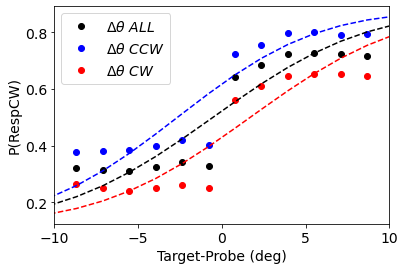

In [25]:
bns_stim= np.linspace(-15,15,20)

obs = observations
d_use_deg = d_use_radians*90/pi

fit_gauss_pool = scipy.optimize.minimize(min_fun_gauss,x0=(5,0),args=((observations,d_use_deg),),bounds=((0.01,45),(-45,45)))
avg_percieve = (do_bining(bns_stim,1,d_use_deg,observations-.5,flip=0)+.5)

fit_gauss_pool_ccw = scipy.optimize.minimize(min_fun_gauss,(5,0),args=((observations[d_ori<0],d_use_deg[d_ori<0]),),bounds=((0.01,45),(-45,45)))
avg_percieve_ccw = (do_bining(bns_stim,1,d_use_deg[d_ori<0],obs[d_ori<0]-.5,flip=0)+.5)

fit_gauss_pool_cw = scipy.optimize.minimize(min_fun_gauss,(5,0),args=((observations[d_ori>0],d_use_deg[d_ori>0]),),bounds=((0.01,45),(-45,45)))
avg_percieve_cw = (do_bining(bns_stim,1,d_use_deg[d_ori>0],obs[d_ori>0]-.5,flip=0)+.5)

pool_params = fit_gauss_pool.x
pool_params_ccw =fit_gauss_pool_ccw.x
pool_params_cw =fit_gauss_pool_cw.x

ind_cut =3
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve[ind_cut:-ind_cut],'ko',label='$\Delta\\theta~ ALL$')
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve_ccw[ind_cut:-ind_cut],'bo',label='$\Delta\\theta~ CCW$')
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve_cw[ind_cut:-ind_cut],'ro',label='$\Delta\\theta~ CW$')


G = scipy.stats.norm(-pool_params[1],pool_params[0]) # swich bias direction because these fits are for perception
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'k--')

G = scipy.stats.norm(-pool_params_ccw[1],pool_params_ccw[0])
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'b--')

G = scipy.stats.norm(-pool_params_cw[1],pool_params_cw[0])
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'r--')

plt.ylabel('P(RespCW)')
plt.xlabel('Target-Probe (deg)')
plt.xlim(-10,10)
plt.legend()
plt.show()

fit_sd = pool_params[0]

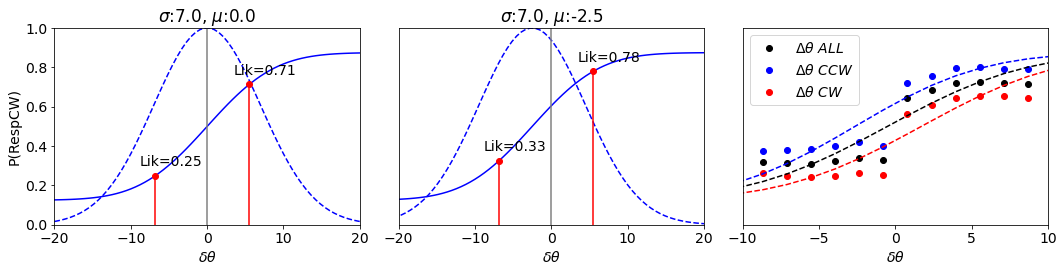

In [26]:
bns_plot = np.linspace(-30,30,100)
# params_use = [pool_params,pool_params_ccw]
params_use = [[7,0],[7,-2.5]]
plt.figure(figsize=(15,4))
xl=[-10,10]
xl=[-20,20]
cols = ['k','b']
for i in range(2):
    plt.subplot(1,3,i+1)
    if i==0:
        plt.ylabel('P(RespCW)')
    
    G = scipy.stats.norm(params_use[i][1],params_use[i][0]) 
    pdf = G.pdf(bns_plot)
    pdf/=np.max(pdf)
    cdf = (G.cdf(bns_plot)*(1-GUESS_RATE)+GUESS_RATE*0.5)
    plt.plot(bns_plot,pdf,cols[1]+'--')
    plt.plot(bns_plot,cdf,cols[1])

    trial = 6
    t_p = [6,8]
    for trial in t_p:
        cdf_probe = (G.cdf(d_use_deg[trial])*(1-GUESS_RATE)+GUESS_RATE*0.5)
        plt.plot([d_use_deg[trial],d_use_deg[trial]],[0,cdf_probe],'r-')
        plt.plot([d_use_deg[trial]],[cdf_probe],'ro')
        my_str   ='Lik=%.2f' %cdf_probe
        plt.annotate(my_str,(d_use_deg[trial]-2,cdf_probe+.05))#,fontsize=12)

    plt.plot([0,0],[0,1],'gray')
    plt.xlim(xl)
    plt.ylim(0,1)
    
#     plt.xlabel('Target-Probe (deg)')
    plt.xlabel('$\delta\\theta$')
#     plt.title('SD:.2f, mu:%.2f' %params_use[i])
    plt.title('$\sigma$:%.1f, $\mu$:%.1f' %(params_use[i][0],params_use[i][1]))
plt.yticks([])
plt.subplot(1,3,3)
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve[ind_cut:-ind_cut],'ko',label='$\Delta\\theta~ ALL$')
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve_ccw[ind_cut:-ind_cut],'bo',label='$\Delta\\theta~ CCW$')
plt.plot(-bns_stim[ind_cut:-ind_cut],avg_percieve_cw[ind_cut:-ind_cut],'ro',label='$\Delta\\theta~ CW$')


G = scipy.stats.norm(-pool_params[1],pool_params[0]) # swich bias direction because these fits are for perception
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'k--')

G = scipy.stats.norm(-pool_params_ccw[1],pool_params_ccw[0])
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'b--')

G = scipy.stats.norm(-pool_params_cw[1],pool_params_cw[0])
fit_gauss = (G.cdf(bns_stim)*(1-GUESS_RATE)+GUESS_RATE*0.5)
plt.plot(bns_stim[ind_cut:-ind_cut],fit_gauss[ind_cut:-ind_cut],'r--')
plt.ylim(0,1)
# plt.xlabel('Target-Probe (deg)')
plt.xlabel('$\delta\\theta$')
plt.xlim(-10,10)
# plt.xlim(xl)

plt.legend()
plt.yticks([])
plt.tight_layout()
# sav_fig('Explain_SDT_3_rev')
# sav_fig('S1_B')
plt.show()

# Okay, down to the main analysis. 
1. Avg SD curve across particpants
1. Fit DoGs to raw subject data
1. Binary Split SD bars
1. Avg variance curve across partipants
1. Fit DDoGs to raw subject data
1. Correlation bias/ variance

# Get sliding measures of bias and variance

In [27]:
n_bns = 91 
overlap = 8
bns = np.linspace(-90,90,n_bns)
subjs = S.subj.unique()

In [28]:
def run_SDT_subj(subj):
    this_S = S[(S.subj==subj)&good_task]

    grouper = this_S['d_ori'].values
    d_use_deg = this_S['d_stim'].values
    observations = this_S['respCW'].values

    sdt_results_gauss = do_bining(bns,overlap,grouper,observations,d_use_deg,flip=1)
    return sdt_results_gauss

def run_percent_subj(subj):
    this_S = S[(S.subj==subj)&good_task]

    grouper = this_S['d_ori'].values
    d_use_deg = this_S['d_stim'].values
    observations = this_S['respCW'].values
    correct = this_S['correct'].values

    p_resp_cw = do_bining(bns,overlap,grouper,observations,flip=3)
    p_correct = do_bining(bns,overlap,grouper,correct,flip=2)
    return (p_resp_cw,p_correct)

def run_SDT_subj_no_flip(subj):
    this_S = S[(S.subj==subj)&good_task]

    grouper = this_S['d_ori'].values
    d_use_deg = this_S['d_stim'].values
    observations = this_S['respCW'].values

    sdt_results_gauss = do_bining(bns,overlap,grouper,observations,d_use_deg,flip=0)
    return sdt_results_gauss

def run_percent_subj_no_flip(subj):
    this_S = S[(S.subj==subj)&good_task]

    grouper = this_S['d_ori'].values
    d_use_deg = this_S['d_stim'].values
    observations = this_S['respCW'].values
    correct = this_S['correct'].values

    p_resp_cw = do_bining(bns,overlap,grouper,observations,flip=0)
    p_correct = do_bining(bns,overlap,grouper,correct,flip=0)
    return (p_resp_cw,p_correct)

In [29]:
overlap=4
# note, if you have issue with running in parallel, can just run list(map(fun,subjs))
with Pool(20) as pool:
    SDT_ALL = np.array(pool.map(run_SDT_subj,S.subj.unique()))
    
with Pool(20) as pool:
    percent_all = np.array(pool.map(run_percent_subj,S.subj.unique()))

/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-pa

In [31]:
overlap=4
with Pool(20) as pool:
    SDT_ALL_no_flip = np.array(pool.map(run_SDT_subj_no_flip,S.subj.unique()))
    
with Pool(20) as pool:
    percent_all_no_flip = np.array(pool.map(run_percent_subj_no_flip,S.subj.unique()))

/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/AD/tsheehan/anaconda3/envs/myenv/lib/python3.8/site-package

# Fit DoG Models

In [32]:
# DoG
good_task = (S.trial>0)&(~S.respCW.isna())&(np.abs(S.d_stim)<15)
def fit_DoG_subj(subj,return_full=0):
    this_S = S[(S.subj==subj)&good_task]
    n_trials = len(this_S)
    if n_trials > 100: # 130
        vals = (this_S['respCW'].values,-this_S['d_stim'].values,this_S['d_ori'].values)

        fit_dog_this = scipy.optimize.minimize(min_fun_dog_percept,x0=(0,.03),args=(vals,),method='Nelder-Mead')
        if return_full:
            return fit_dog_this
        if fit_dog_this.success:
            return fit_dog_this.x
        else: 
            fit_dog_this = scipy.optimize.minimize(min_fun_dog_percept,x0=(0,.03),args=(vals,),bounds=((-10,10),(0.0001,0.20)))
            return fit_dog_this.x
        
def fit_DoG_subj_sd(subj,return_full=0):
    this_S = S[(S.subj==subj)&good_task]
    n_trials = len(this_S)
    if n_trials > 100: # 130
        vals = (this_S['respCW'].values,-this_S['d_stim'].values,this_S['d_ori'].values)

        fit_dog_this = scipy.optimize.minimize(min_fun_dog_percept_sd,x0=(0,.03,7),args=(vals,),method='Nelder-Mead')
        if return_full:
            return fit_dog_this
        if fit_dog_this.success:
            return fit_dog_this.x
        else: 
            fit_dog_this = scipy.optimize.minimize(min_fun_dog_percept_sd,x0=(0,.03,7),args=(vals,),bounds=((-10,10),(0.0001,0.20),(0.5,20)))
            return fit_dog_this.x
        
def get_FWHM(fit_shape):
    # FWHM of fit DoG
    n_samp,n_subj = fit_shape.shape
    hlf_amp = np.max(fit_shape,0)/2
    d_hlf_min = np.abs(fit_shape-hlf_amp)
    hlf_inds = np.argsort(d_hlf_min,0)
    
    n_try = 10
    FWHM = np.zeros(n_subj)*np.nan
    for i in range(n_subj):
        these_inds = hlf_inds[:,i]
        ind0,ind1=these_inds[:2]
        for j in range(n_try):
            if np.abs(ind0-ind1)<10:
                ind1=these_inds[j+2]
            else:
                FWHM[i] = np.abs(bns_tight[ind0]-bns_tight[ind1])
    return FWHM

In [33]:
with Pool(20) as pool:
    DoG_ALL_sd = np.array(pool.map(fit_DoG_subj_sd,S.subj.unique()))
    
bns_tight = np.linspace(-90,90,1000)
fit_shape_dog = np.array([DoG(d,bns_tight) for d in DoG_ALL_sd[:,:2]]).T
FWHM = get_FWHM(fit_shape_dog)
bad_DoG = (np.isnan(DoG_ALL_sd[:,0]) | (np.abs(DoG_ALL_sd[:,0])>=15) | (DoG_ALL_sd[:,1]>0.3) | (DoG_ALL_sd[:,2]>25)) 
bad_fit = bad_DoG

# t-test DoG amp

N Subj 47, N bad DoG 0


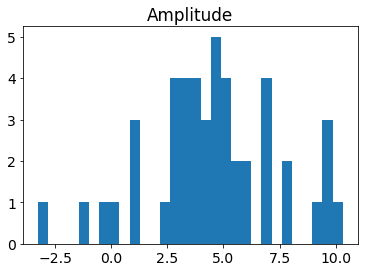

Ttest_1sampResult(statistic=10.721128429525258, pvalue=4.243669373404179e-14)


In [34]:
# Visualize DoG Parameters

print('N Subj %d, N bad DoG %d' %(len(bad_DoG),np.sum(bad_fit)))


plt.hist(DoG_ALL_sd[~bad_fit,0],30)
plt.title('Amplitude')
plt.show()
print(scipy.stats.ttest_1samp(DoG_ALL_sd[~bad_DoG,0],0))

# Print Stats

In [35]:
# get N subject that completed each version
# 25 R
Su = S[np.isin(S.subj,subjs[~bad_fit])]
s_by_subj = Su.groupby('subj').seq_type.unique().reset_index()
sess_R = ['R','RT','RB']
sess_markov = ['S4','S4O','S4R']
print('Total Number of Subjects: %d, after cleaning %d' %(len(S_og.subject.unique()), len(S.subj.unique())))

print('# Too bad: %d, Too lazy %d, Bad Fit %d' %(len(too_bad),len(too_lazy),np.sum(bad_fit)))
print()

print('Both:',np.sum([np.any(np.isin(s,sess_markov)) & np.any(np.isin(s,sess_R)) for s in s_by_subj.seq_type.values]))
print('Random Stim Only:',np.sum([np.any(np.isin(s,sess_R)) & ~ np.any(np.isin(s,sess_markov)) for s in s_by_subj.seq_type.values]))
print('Markov Only:',np.sum([~np.any(np.isin(s,sess_R)) & np.any(np.isin(s,sess_markov)) for s in s_by_subj.seq_type.values]))

print()
n_block = Su.groupby('subj').session.apply(lambda x: len(np.unique(x))).values
print('Num Blocks: %.3f +/- %.3f; Range [%d, %d]'%(np.mean(n_block),std_e(n_block),np.min(n_block),np.max(n_block)))

n_trials = Su.groupby('subj').size().values
print('Num Trials: %.3f +/- %.3f; Range [%d, %d]'%(np.mean(n_trials),std_e(n_trials),np.min(n_trials),np.max(n_trials)))

acc = Su.groupby('subj').correct.mean().values*100
print('Accuracy: %.3f +/- %.3f; Range [%d, %d]'%(np.mean(acc),std_e(acc),np.min(acc),np.max(acc)))

# qf = lambda x: np.median(np.abs(x))
qf = lambda x: scipy.stats.mode(np.abs(x))[0]

d_stim = Su.groupby('subj').d_stim.apply(qf).values
print('d stim: %.3f +/- %.3f; Range [%d, %d]'%(np.mean(d_stim),std_e(d_stim),np.min(d_stim),np.max(d_stim)))


Total Number of Subjects: 56, after cleaning 47
# Too bad: 7, Too lazy 2, Bad Fit 0

Both: 14
Random Stim Only: 25
Markov Only: 8

Num Blocks: 5.723 +/- 0.238; Range [3, 9]
Num Trials: 417.936 +/- 24.017; Range [204, 988]
Accuracy: 69.429 +/- 0.776; Range [60, 83]
d stim: 4.613 +/- 0.272; Range [1, 8]


# Plot Serial Dependence Curve

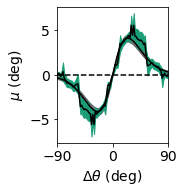

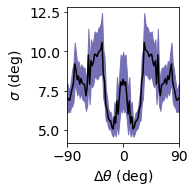

In [36]:
plt.figure(figsize=(2,2.5))
sem_plot(bns_tight,fit_shape_dog[:,~bad_fit].T,color='k',label='$DoG$',alpha=.5)
# sem_plot(bns,SDT_ALL[~bad_fit,1,:],color=ct[0],label='$Mean$')
sem_plot(bns,SDT_ALL[~bad_fit,1,:],color=ct[0],label='$Mean$')

plt.xticks([-90,0,90])
# plt.xticks([-90,-45,0,45,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\mu$ (deg)')
plt.plot([-90,90],[0,0],'k--')

# sav_fig('Fig1B_fix_thin')
# sav_fig('S4_A')
plt.show()
plt.figure(figsize=(2,2.5))
# sem_plot(bns,SDT_ALL[~bad_fit,0,:],color=ct[1],label='$Mean$')
sem_plot(bns,SDT_ALL[~bad_fit,0,:],color=ct[1],label='$Mean$')
plt.xticks([-90,0,90])
# plt.xticks([-90,-45,0,45,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\sigma$ (deg)')
# plt.legend()
# sav_fig('S4_B_thin')

# sav_fig('Fig1C')
plt.show()

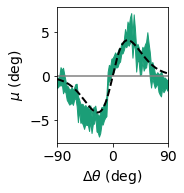

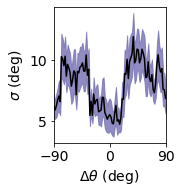

In [37]:
# same but without flipping...

plt.figure(figsize=(2,2.5))

# sem_plot(bns,SDT_ALL[~bad_fit,1,:],color=ct[0],label='$Mean$')
sem_plot(bns,SDT_ALL_no_flip[~bad_fit,1,:],do_line=0,color=ct[0],label='$Mean$')
# sem_plot(bns_tight,fit_shape_dog[:,~bad_fit].T,color='m',label='$DoG$',alpha=.5)
plt.plot(bns_tight,np.mean(fit_shape_dog[:,~bad_fit],1),'k--',linewidth=2)#,color='k',alpha=1)

plt.xticks([-90,0,90])
# plt.xticks([-90,-45,0,45,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\mu$ (deg)')
plt.plot([-90,90],[0,0],'gray')

# sav_fig('Fig1B_fix_thin')
# sav_fig('Fig1C_noFlip')
# sav_fig('Fig1C_noFlip_randomOnly')
plt.show()
plt.figure(figsize=(2,2.5))
# sem_plot(bns,SDT_ALL[~bad_fit,0,:],color=ct[1],label='$Mean$')
sem_plot(bns,SDT_ALL_no_flip[~bad_fit,0,:],do_line=1,color=ct[1],label='$Mean$',alpha=.8)
plt.xticks([-90,0,90])
# plt.xticks([-90,-45,0,45,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\sigma$ (deg)')
# plt.legend()
# sav_fig('S4_B_thin')

# sav_fig('Fig1F_noFlip')
# sav_fig('Fig1F_noFlip_randomOnly')
plt.show()

# Bias vs Variance

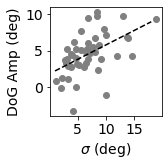

Correlation $\mu ~\sigma$
r(45) = 0.52 (p=0.00010)


In [38]:
# x,y = FITS_ALL[~bad_fit,2,0],-FITS_ALL[~bad_fit,2,1]
y,x = DoG_ALL_sd[~bad_fit,0],DoG_ALL_sd[~bad_fit,2]

# plt.plot(DoG_ALL_sd[:,0],DoG_ALL_sd[:,2],'ko')

plt.figure(figsize=(2,2))
plt.plot(x,y,'o',color='gray')
rho = scipy.stats.pearsonr(x,y)
# rho2 = scipy.stats.spearmanr(x,y)
# plt.title('%.2f (p=%.1e)' %(rho[0],rho[1]/2))
# plt.title('%.2f (p=%.5f)' %(rho))
plt.xlabel('$\sigma$ (deg)')
# plt.ylabel('$\mu$ (deg)')
plt.ylabel('DoG Amp (deg)')
# plt.show()
xl = (0,21)
yl = (-5,12)

xl = (0,17)
yl = (-1,12)
# plt.xlim(xl)
# plt.ylim(yl)

pred = np.stack((np.ones(len(y)),x)).T
fit = np.linalg.lstsq(pred,y,rcond=None)[0]
x_try = np.array([1,18])
plt.plot(x_try,x_try*fit[1]+fit[0],'k--')
# plt.yticks(np.linspace(-2,6,5))

# sav_fig('Fig1E_fix')
# sav_fig('Fig1E_fix_randomOnly')
# sav_fig('S4_C')
plt.show()  

print('Correlation $\mu ~\sigma$')
print('r(%d) = %.2f (p=%.5f)' %(np.sum(~bad_fit)-2,rho[0],rho[1]/2))

# Get SD data split at threshold

In [40]:
# do robustly because n_trial problem
# lets do splitting data, threshold and @ 0
df_thresh_match_all = pd.DataFrame()
n_reps = 61 # can increase number to make stats more consistent between runs
thresh = 30
thresh_try = np.arange(20,41,5)
thresh_try = [30]
good_task = (S.trial>0)&(~S.respCW.isna())&(np.abs(S.d_stim)<15)
grp_name = ['Close','Far']
for subj in subjs:
    these_ind = good_task.values&(S.subj.values==subj)
    for thresh in thresh_try:
        for grp in range(2): # inside, outside
            if grp==0:
                this_grp = np.abs(S['d_ori'].values)<thresh
                n0 = np.sum(these_ind&this_grp) # smaller group #
                n_lap = 1
            elif grp==1: 
                this_grp = np.abs(S['d_ori'].values)>thresh
                n_lap = n_reps
            ind_use = np.where(these_ind&this_grp)[0]
            n_this = np.sum(these_ind&this_grp)
            percent_correct = np.mean(S[these_ind&this_grp].correct)
            if n_this<n0:
                print(subj,thresh,'Too small')
                n0=n_this
                n_lap=1

            fits=np.zeros((n_lap,2))
            for i in range(n_lap):
                this_S = S.iloc[np.random.choice(ind_use,n0,replace=0)]

                # Flip values
                this_resp = this_S['respCW'].values.copy()
                this_d_stim = this_S['d_stim'].values.copy()
                this_resp[this_S.d_ori<0] = 1-this_resp[this_S.d_ori<0]
                this_d_stim[this_S.d_ori<0] *= -1

                vals0 = (this_resp,this_d_stim)
                fit_gauss_this = scipy.optimize.minimize(min_fun_gauss,x0=(3,0),args=((vals0),))
                xHat = fit_gauss_this.x
                if (fit_gauss_this.success==False) or (xHat[0]<.1) or(xHat[0]>30) or (abs(xHat[1]>20)):
                    fit_gauss_this = scipy.optimize.minimize(min_fun_gauss,x0=(3,0),args=((vals0),),method='Nelder-Mead')
                    xHat = fit_gauss_this.x
                    if (fit_gauss_this.success==False) or (xHat[0]<.1) or(xHat[0]>30) or (abs(xHat[1]>20)):
                        fit_gauss_this = scipy.optimize.minimize(min_fun_gauss,x0=(3,0),args=((vals0),),bounds=((0.01,20),(-20,20)))
                        assert fit_gauss_this.success, 'bad fit still!'
                fits[i,:]= fit_gauss_this.x
            df_thresh_match_all = df_thresh_match_all.append({'thresh':thresh,'subj':subj,'d_ori':grp_name[grp],'p_correct':percent_correct,'sd':np.median(fits[:,0],0),'bias':np.median(fits[:,1],0)},ignore_index=1)

<ipython-input-40-c7f2e14e7552>:15: RuntimeWarning: invalid value encountered in less
  this_grp = np.abs(S['d_ori'].values)<thresh
<ipython-input-40-c7f2e14e7552>:19: RuntimeWarning: invalid value encountered in greater
  this_grp = np.abs(S['d_ori'].values)>thresh
<ipython-input-40-c7f2e14e7552>:15: RuntimeWarning: invalid value encountered in less
  this_grp = np.abs(S['d_ori'].values)<thresh
<ipython-input-40-c7f2e14e7552>:19: RuntimeWarning: invalid value encountered in greater
  this_grp = np.abs(S['d_ori'].values)>thresh
<ipython-input-40-c7f2e14e7552>:15: RuntimeWarning: invalid value encountered in less
  this_grp = np.abs(S['d_ori'].values)<thresh
<ipython-input-40-c7f2e14e7552>:19: RuntimeWarning: invalid value encountered in greater
  this_grp = np.abs(S['d_ori'].values)>thresh
<ipython-input-40-c7f2e14e7552>:15: RuntimeWarning: invalid value encountered in less
  this_grp = np.abs(S['d_ori'].values)<thresh
<ipython-input-40-c7f2e14e7552>:19: RuntimeWarning: invalid value e

# Median split based on performance!
#- bias, variance, and variance close/far split

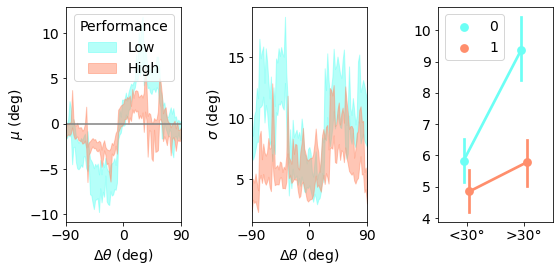

In [41]:
high_performing_subj = y<np.median(y)
cols_perf = ['#6cfff5','#ff8e6c']
SDT_these = SDT_ALL_no_flip[~bad_fit,1,:] # no bad fits... but keep just in case
DoG_these = fit_shape_dog[:,~bad_fit].T

al=.5
plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
sem_plot(bns,SDT_these[~high_performing_subj],do_line=0,color=cols_perf[0],label='Low',alpha=al)
sem_plot(bns,SDT_these[high_performing_subj],do_line=0,color=cols_perf[1],label='High',alpha=al)
plt.legend(title='Performance')

plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\mu$ (deg)')
plt.plot([-90,90],[0,0],'gray')


plt.subplot(1,3,2)
SDT_var_these = SDT_ALL_no_flip[~bad_fit,0,:] # no bad fits... but keep just in case
sem_plot(bns,SDT_var_these[~high_performing_subj],do_line=0,within_E=1,color=cols_perf[0],alpha=al)
sem_plot(bns,SDT_var_these[high_performing_subj],do_line=0,within_E=1,color=cols_perf[1],alpha=al)

plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('$\sigma$ (deg)')

plt.subplot(1,3,3)
df_thresh_match_all['high_performing'] = 0
df_thresh_match_all.loc[np.isin(df_thresh_match_all.subj,subjs[high_performing_subj]),'high_performing']=1
sns.pointplot(x='d_ori',y='sd',hue='high_performing',data=df_thresh_match_all,ci=68,palette=cols_perf,dodge=.1)
# plt.ylabel('$\sigma$ (deg)')
plt.ylabel('')

plt.xlabel('')
plt.xticks([0,1],['<30°','>30°'])
plt.legend()
plt.tight_layout()
# sav_fig('MedSplit_BiasVar')
plt.show()


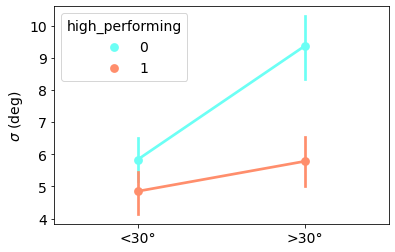

Ttest_relResult(statistic=-4.146526399746272, pvalue=0.0003907595481264127)
Ttest_relResult(statistic=-2.135483069477684, pvalue=0.044102685322338686)
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      sd       
No. Observations:       94           Method:                  REML     
No. Groups:             47           Scale:                   5.5450   
Min. group size:        2            Log-Likelihood:          -243.6414
Max. group size:        2            Converged:               Yes      
Mean group size:        2.0                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     5.835    0.779  7.495 0.000  4.309  7.361
d_ori[T.Far]                  3.540    0.680  5.208 0.000  2.208  4.872
hi

In [42]:
sns.pointplot(x='d_ori',y='sd',hue='high_performing',data=df_thresh_match_all,ci=68,palette=cols_perf)
plt.ylabel('$\sigma$ (deg)')

plt.xlabel('')
plt.xticks([0,1],['<30°','>30°'])
plt.show()

#- do hue based on subject performance.
# stats
thresh = 30
vals = np.array([df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Close')&(df_thresh_match_all.thresh==thresh),'sd'],
                    df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Far')&(df_thresh_match_all.thresh==thresh),'sd']])

print(scipy.stats.ttest_rel(vals[0,~high_performing_subj],vals[1,~high_performing_subj])) #- note that stats change between runs due to bootstrapping
print(scipy.stats.ttest_rel(vals[0,high_performing_subj],vals[1,high_performing_subj])) #- note that stats change between runs due to bootstrapping

# lets test for interaction!
mdl = smf.mixedlm('sd~d_ori*high_performing',data=df_thresh_match_all,groups=df_thresh_match_all['subj']).fit()
print(mdl.summary())

# also show DoG still sig in both grousp
print('DoG By Group')
print(scipy.stats.ttest_1samp(DoG_ALL_sd[~high_performing_subj,2],0))
print(scipy.stats.ttest_1samp(DoG_ALL_sd[high_performing_subj,2],0))
print(scipy.stats.ttest_ind(DoG_ALL_sd[high_performing_subj,2],DoG_ALL_sd[~high_performing_subj,2]))

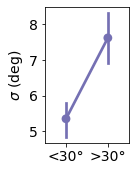

Ttest_relResult(statistic=-4.376632439964065, pvalue=6.872093269028412e-05)


In [45]:
plt.figure(figsize=(1.5,2.5))
sns.pointplot(x='d_ori',y='sd',data=df_thresh_match_all,ci=68,color=ct[1])
plt.ylabel('$\sigma$ (deg)')

plt.xlabel('')
plt.xticks([0,1],['<30°','>30°'])
# sav_fig('Fig1_DSig_thin')
# sav_fig('Fig1_DSig_thin_randomOnly')
# sav_fig('S4_B2')
plt.show()

thresh = 30
vals = np.array([df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Close')&(df_thresh_match_all.thresh==thresh),'sd'],
                    df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Far')&(df_thresh_match_all.thresh==thresh),'sd']])

print(scipy.stats.ttest_rel(vals[0,~bad_fit],vals[1,~bad_fit])) #- note that stats change between runs due to bootstrapping
# vals[0] 

In [46]:
print('D-Ori Stats Non-parametric')
for thresh in thresh_try:
    vals = np.array([df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Close')&(df_thresh_match_all.thresh==thresh),'p_correct'],
                    df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Far')&(df_thresh_match_all.thresh==thresh),'p_correct']])
    ts = scipy.stats.ttest_rel(vals[0,~bad_fit],vals[1,~bad_fit])
    print('%d: T(%d)=%.2f (p=%.5f)' %(thresh,np.sum(~bad_fit)-1,ts[0],ts[1]/2))
    
print('D-Ori Stats Parametric')
for thresh in thresh_try:
    vals = np.array([df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Close')&(df_thresh_match_all.thresh==thresh),'sd'],
                    df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Far')&(df_thresh_match_all.thresh==thresh),'sd']])
    ts = scipy.stats.ttest_rel(vals[0,~bad_fit],vals[1,~bad_fit])
    print('%d: T(%d)=%.2f (p=%.5f)' %(thresh,np.sum(~bad_fit)-1,ts[0],ts[1]/2))

D-Ori Stats Non-parametric
30: T(46)=3.66 (p=0.00032)
D-Ori Stats Parametric
30: T(46)=-4.38 (p=0.00003)


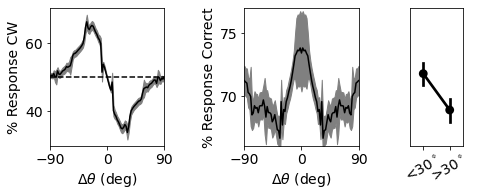

In [47]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
nan_sem_plot(bns,percent_all[:,0,:]*100,color='gray')
# plt.xticks([-90,-45,0,45,90])
plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('% Response CW')
plt.plot([-90,90],[50,50],'k--')

plt.subplot(1,3,2)
nan_sem_plot(bns,percent_all[:,1,:]*100,color='gray')
plt.xticks([-90,-45,0,45,90])
plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('% Response Correct')
yl=(66,77)
plt.ylim(yl)

plt.tight_layout()
plt.subplot(1,6,5)
df_thresh_match_all['percent'] = df_thresh_match_all['p_correct']*100
sns.pointplot(data=df_thresh_match_all,x='d_ori',y='percent',color='k',ci=68)
# plt.plot([0,1],vals*100,'gray',alpha=.3)
plt.xlabel('')
plt.xticks([0,1],('<30$^\circ$','>30$^\circ$'),rotation=30)
plt.ylim(yl)
plt.ylabel('')
plt.yticks([])
# sav_fig('Beh_percent_all')
# sav_fig('Fig_SX_Percent_All')
# plt.tight_layout()
# sav_fig('S2A')
plt.show()
# percent_all.shape

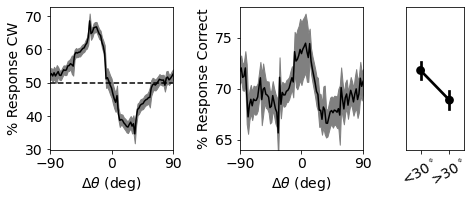

In [49]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
nan_sem_plot(bns,percent_all_no_flip[:,0,:]*100,color='gray')
# plt.xticks([-90,-45,0,45,90])
plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('% Response CW')
plt.plot([-90,90],[50,50],'k--')

plt.subplot(1,3,2)
nan_sem_plot(bns,percent_all_no_flip[:,1,:]*100,color='gray')
plt.xticks([-90,-45,0,45,90])
plt.xticks([-90,0,90])
plt.xlim([-90,90])
plt.xlabel("$\Delta\\theta$ (deg)")
plt.ylabel('% Response Correct')
yl=(64,78)
plt.ylim(yl)

plt.tight_layout()
plt.subplot(1,6,5)
df_thresh_match_all['percent'] = df_thresh_match_all['p_correct']*100
sns.pointplot(data=df_thresh_match_all,x='d_ori',y='percent',color='k',ci=68)
# plt.plot([0,1],vals*100,'gray',alpha=.3)
plt.xlabel('')
plt.xticks([0,1],('<30$^\circ$','>30$^\circ$'),rotation=30)
plt.ylim(yl)
plt.ylabel('')
plt.yticks([])
# sav_fig('Beh_percent_all')
# sav_fig('Fig_SX_Percent_All')
# plt.tight_layout()
# sav_fig('Fig_1BDE_npFlip_randomOnly')
plt.show()
# percent_all.shape

# Are variance effects as f(dTheta) driven by # of trials near cardinal?

In [ ]:
# test for matching distributions close/ far from prev stim
# just do t-test on being within 22.5 deg of cardinal 

In [50]:
card_thresh = 22.5
card_ori = (np.abs(S.orient0.values)<card_thresh) | (np.abs(wrap(S.orient0.values-90))<card_thresh)
close_prev = np.abs(S.d_ori.values)<30

# plt.hist(S.orient0.values[card_ori],60)
prop_card = np.zeros((len(subjs),2))
for si,subj in enumerate(subjs):
    these_ind = good_task.values&(S.subj.values==subj)
    prop_card[si,0] = np.sum((these_ind&close_prev&card_ori))/np.sum((these_ind&close_prev))
    prop_card[si,1] = np.sum((these_ind&~close_prev&card_ori))/np.sum((these_ind&~close_prev))
    

<ipython-input-50-d14f4ffeeeed>:3: RuntimeWarning: invalid value encountered in less
  close_prev = np.abs(S.d_ori.values)<30


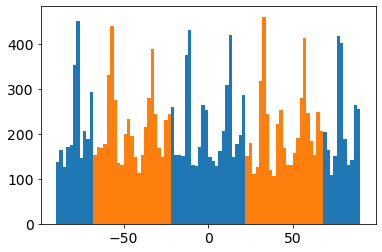

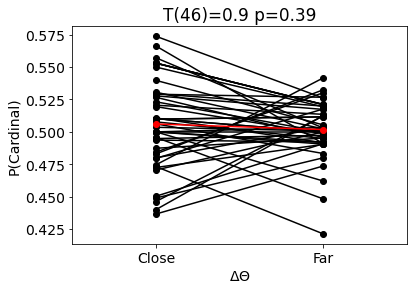

Close 0.506+/-0.0049
Far 0.502+/-0.0031


In [51]:
plt.hist(S.orient0[card_ori],bns)
plt.hist(S.orient0[~card_ori],bns)
plt.show()

plt.plot([0,1],prop_card.T,'ko-')
plt.plot([0,1],np.mean(prop_card,0),'ro-')
plt.xlim([-.5,1.5])
plt.xticks([0,1],['Close','Far'])
plt.xlabel('$\Delta \\Theta$')
plt.ylabel('P(Cardinal)')
this_t= scipy.stats.ttest_rel(prop_card[:,0],prop_card[:,1])
plt.title('T(%d)=%.1f p=%.2f' %(len(subjs)-1,*this_t))
plt.show()

print('Close %.3f+/-%.4f' %(np.mean(prop_card[:,0]),std_e(prop_card[:,0])))
print('Far %.3f+/-%.4f' %(np.mean(prop_card[:,1]),std_e(prop_card[:,1])))

# Print all stats

In [52]:
Su = S[np.isin(S.subj,subjs[~bad_fit])]
good_task = (Su.trial>0)&(~Su.respCW.isna())&(np.abs(Su.d_stim)<15)
Suu = Su[good_task]
def mag(x): return np.mean(np.abs(x))
print('N=%d Acc: %.2f +/- %.2f'%(len(Suu.subj.unique()),np.mean(Suu.groupby('subj').correct.mean().values*100),
                                std_e(Suu.groupby('subj').correct.mean().values*100)))
print('Avg Difficulty %.2f +/- %.2f' %(np.mean(Suu.groupby('subj').d_stim.apply(mag)),std_e(Suu.groupby('subject').d_stim.apply(mag)) ))

# print('SD: %.2f +/- %.2f' %(np.mean(SD_ALL[~bad_fit,0]),std_e(SD_ALL[~bad_fit,0]) ) )
# print('Bias: %.2f +/- %.2f' %(np.mean(SD_ALL[~bad_fit,1]),std_e(SD_ALL[~bad_fit,1]) ) )

print('DoG Amp: %.2f +/- %.2f' %(np.mean(DoG_ALL_sd[~bad_fit,0]),std_e(DoG_ALL_sd[~bad_fit,0]) ) )
print('DoG width: %.4f +/- %.4f' %(np.mean(DoG_ALL_sd[~bad_fit,1]),std_e(DoG_ALL_sd[~bad_fit,1]) ) )
print('SD, DoG %.2f +/- %.2f' %(np.mean(DoG_ALL_sd[~bad_fit,2]),std_e(DoG_ALL_sd[~bad_fit,2]) ) )

print('FWHM: %.2f +/- %.2f' % (np.nanmean(FWHM),std_e((FWHM)) ))

t_DoG = scipy.stats.ttest_1samp(DoG_ALL_sd[~bad_fit,0],0)
print(t_DoG)
# median split bias + ttest


N=47 Acc: 69.77 +/- 0.82
Avg Difficulty 4.95 +/- 0.25
DoG Amp: 4.53 +/- 0.42
DoG width: 0.0278 +/- 0.0016
SD, DoG 6.79 +/- 0.54
FWHM: 42.91 +/- 1.84
Ttest_1sampResult(statistic=10.721128429525258, pvalue=4.243669373404179e-14)
